# 18. 离线强化学习

## 18.1 简介
- 在前面的学习中，我们已经对强化学习有了不少了解。无论是**在线策略**（on-policy）算法还是**离线策略**（off-policy）算法，都有一个共同点：智能体在训练过程中可以不断和环境交互，得到新的反馈数据。二者的区别主要在于在线策略算法会直接使用这些反馈数据，而离线策略算法会先将数据存入经验回放池中，需要时再采样。然而，在现实生活中的许多场景下，让尚未学习好的智能体和环境交互可能会导致危险发生，或是造成巨大损失。例如，在训练自动驾驶的规控智能体时，如果让智能体从零开始和真实环境进行交互，那么在训练的最初阶段，它操控的汽车无疑会横冲直撞，造成各种事故。再例如，在推荐系统中，用户的反馈往往比较滞后，统计智能体策略的回报需要很长时间。而如果策略存在问题，早期的用户体验不佳，就会导致用户流失等后果。因此，**离线强化学习**（offline reinforcement learning）的目标是，在智能体不和环境交互的情况下，仅从已经收集好的确定的数据集中，通过强化学习算法得到比较好的策略。离线强化学习和在线策略算法、离线策略算法的区别如图 18-1 所示。

<div align="center">
    <img src="./image/18-1.png" style = "width: 100%">
    <center>图 18-1 离线强化学习和在线策略算法、离线策略算法的区别</center>
</div>

## 18.2 批量限制 Q-learning 算法
- 图 18-1 中的离线强化学习和离线策略强化学习很像，都要从经验回放池中采样进行训练，并且离线策略算法的策略评估方式也多种多样。因此，研究者们最开始尝试将离线策略算法直接照搬到离线的环境下，仅仅是去掉算法中和环境交互的部分。然而，这种做法完全失败了。研究者进行了 3 个简单的实验。第一个实验，作者使用 DDPG 算法训练了一个智能体，并将智能体与环境交互的所有数据都记录下来，再用这些数据训练离线 DDPG 智能体。第二个实验，在线 DDPG 算法在训练时每次从经验回放池中采样，并用相同的数据同步训练离线 DDPG 智能体，这样两个智能体甚至连训练时用到的数据顺序都完全相同。第三个实验，在线 DDPG 算法在训练完毕后作为专家，在环境中采集大量数据，供离线 DDPG 智能体学习。这 3 个实验，即完全回放、同步训练、模仿训练的结果依次如图 18-2 所示。

<div align="center">
    <img src="./image/18-2.png" style = "width: 100%">
    <center>图 18-2 在线算法（橙色）和对应的离线算法（蓝色)的实验结果，从左到右依次为完全回放、同步训练、模仿训练</center>
</div>

- 让人惊讶的是，3 个实验中，离线 DDPG 智能体的表现都远远差于在线 DDPG 智能体，即便是第二个实验的同步训练都无法提高离线智能体的表现。在第三个模仿训练实验中，离线智能体面对非常优秀的数据样本却什么都没学到！针对这种情况，研究者指出，**外推误差**（extrapolation error）是离线策略算法不能直接迁移到离线环境中的原因。

- 外推误差，是指由于当前策略可能访问到的状态动作对与从数据集中采样得到的状态动作对的分布不匹配而产生的误差。为什么在线强化学习算法没有受到外推误差的影响呢？因为对于在线强化学习，即使训练是离线策略的，智能体依然有机会通过与环境交互及时采样到新的数据，从而修正这些误差。但是在离线强化学习中，智能体无法和环境交互。因此，一般来说，离线强化学习算法要想办法尽可能地限制外推误差的大小，从而得到较好的策略。

- 为了减少外推误差，当前的策略需要做到只访问与数据集中相似的 $(s, a)$ 数据。满足这一要求的策略称为**批量限制策略**（batch-constrained policy）。具体来说，这样的策略在选择动作时有 3 个目标：
    - 最小化选择的动作与数据集中数据的选择；
    - 采取动作后能到达与离线数据集中状态相似的状态；
    - 最大化函数 $Q$；

- 对于标准的**表格**（tabular）型环境，状态和动作空间都是离散且有限的。标准的 Q-learning 更新公式可以写为：

$$
Q(s,a)\leftarrow(1-\alpha)Q(s,a)+\alpha(r+\gamma Q(s^{\prime},\mathrm{argmax}_{a^{\prime}}Q(s^{\prime},a^{\prime})))
$$

- 这时，只需要把策略 $\pi$ 能选择的动作限制在数据集 $\mathcal{D}$ 内，就能满足上述 3 个目标的平衡，这样就得到了表格设定下的批量限制 Q-learning（batch-constrained Q-learning，BCQ）算法：

$$
Q(s,a)\leftarrow(1-\alpha)Q(s,a)+\alpha(r+\gamma Q(s^{\prime},\mathrm{argmax}_{a^{\prime}s.t.(s^{\prime},a^{\prime})\in\mathcal{D}}Q(s^{\prime},a^{\prime})))
$$

- 可以证明，如果数据中包含了所有可能的 $(s,a)$ 对，按上式进行迭代可以收敛到最优的价值函数 $Q^*$。

- 连续状态和动作的情况要复杂一些，因为批量限制策略的目标需要被更详细地定义。例如，该如何定义两个状态动作对的距离呢？BCQ 采用了一种巧妙的方法：训练一个生成模型 $G_{\omega}(s)$。对于数据集 $\mathcal{D}$ 和其中的状态 $s$，生成模型 $G_{\omega}(s)$ 能给出与 $\mathcal{D}$ 中数据接近的一系列动作 $a_1, ..., a_n$ 用于 $Q$ 网络的训练。更进一步，为了增加生成动作的多样性，减少生成次数，BCQ 还引入了扰动模型 $\xi_{\phi}(s,a,\Phi)$。输入 $(s,a)$ 时，模型给出一个绝对值最大为 $\phi$ 的微扰并附加在动作上。这两个模型综合起来相当于给出了一个批量限制策略 $\pi$：

$$
\pi(s)=\operatorname{argmax}_{a_i+\xi_\phi(s,a_i,\Phi)}Q_\theta(s,a_i+\xi_\phi(s,a_i,\Phi)),\quad\{a_i\sim G_\omega(s)\}_{i=1}^n
$$

- 其中，生成模型 $G_{\omega}(s)$ 用**变分自动编码器**（variational auto-encoder, VAE）实现；扰动模型直接通过确定性策略梯度算法训练，目标是使$Q$ 函数最大化：

$$
\phi\leftarrow\mathrm{argmax}_\phi\sum_{(s,a)\in\mathcal{D}}Q_\theta(s,a+\xi_\phi(s,a,\Phi))
$$

- 总结起来，BCQ 算法的流程如下：
    - 随机初始化 $Q$ 网络 $Q_{\theta}$、扰动网络 $\xi_{\phi}$、生成网络 $G_{\omega} = \{E_{\omega_1},D_{\omega_2}\}$
    - 用 $\theta$ 初始化目标 $Q$ 网络 $Q_{\theta^-}$，用 $\phi$ 初始化目标扰动网络 $\xi_{\phi'}$
    - for 训练次数 $e = 1 \to E$ do:
        - 从数据集 $\mathcal{D}$ 中采样一定数量的 $(s, a, r, s')$
        - 编码器生成均值和标准差 $\mu, \sigma = E_{\omega_1}(s, a)$
        - 解码器生成动作 $\tilde{a}=D_{\omega_2}(s,z)$，其中 $z \sim \mathcal{N}(\mu, \sigma)$
        - 更新生成模型 $\omega\leftarrow\mathrm{argmin}_\omega\sum(a-\tilde{a})^2+D_{KL}(\mathcal{N}(\mu,\sigma)\parallel\mathcal{N}(0,1))$
        - 从生成模型中采样 $n$ 个动作：$\{a_i\sim G_\omega(s^{\prime})\}_{i=1}^n$
        - 对每个动作施加扰动：$\{a_i\leftarrow a_i+\xi_\phi(s^{\prime},a_i,\phi)\}_{i=1}^n$
        - 计算 $Q$ 网络的目标值 $y=r+\gamma\max_{a_i}Q_{\theta^-}(s^{\prime},a_i)$ 
        - 更新 $Q$ 网络：$\theta\leftarrow\operatorname{argmin}_\theta\sum(y-Q_\theta(s,a))^2$
        - 更新扰动网络：$\phi\leftarrow\mathrm{argmax}_\phi\sum Q_\theta(s,a+\xi_\phi(s,a,\Phi)),a\sim G_\omega(s)$
        - 更新目标 $Q$ 网络：$\theta^-\leftarrow\tau\theta+(1-\tau)\theta^-$
        - 更新目标扰动网络：$\phi^{\prime}\leftarrow\tau\phi+(1-\tau)\phi^{\prime}$
    - end for
    
- 除此之外，BCQ 还使用了一些实现上的小技巧。由于不是 BCQ 的重点，此处不再赘述。考虑到 VAE 不属于本书的讨论范围，并且 BCQ 的代码中有较多技巧，有兴趣的读者可以参阅 BCQ 原文，自行实现代码。此处介绍 BCQ 算法，一是因为它对离线强化学习的误差分析和实验很有启发性，二是因为它是无模型离线强化学习中限制策略集合算法中的经典方法。下面我们介绍另一类直接限制函数 $Q$ 的算法的代表：保守 Q-learning。

## 18.3 保守 Q-learning 算法
- 18.2 节已经讲到，离线强化学习面对的巨大挑战是如何减少外推误差。实验证明，外推误差主要会导致在远离数据集的点上函数 $Q$ 的过高估计，甚至常常出现 $Q$ 值向上发散的情况。因此，如果能用某种方法将算法中偏离数据集的点上的函数 $Q$ 保持在很低的值，或许能消除部分外推误差的影响，这就是**保守 Q-learning**（conservative Q-learning，CQL）算法的基本思想。CQL 在普通的贝尔曼方程上引入一些额外的限制项，达到了这一目标。接下来一步步介绍 CQL 算法的思路。

- 在普通的 Q-learning 中，$Q$ 的更新方程可以写为：

$$
\hat{Q}^{k+1}\leftarrow\operatorname{argmin}_Q\mathbb{E}_{(s,a)\sim\mathcal{D}}\left[\left(Q(s,a)-\hat{\mathcal{B}}^\pi\hat{Q}^k(s,a)\right)^2\right]
$$

- 其中， $\mathcal{B}^\pi$ 是实际计算时策略 $\pi$ 的贝尔曼算子。为了防止 $Q$ 值在各个状态上（尤其是不在数据集中的状态上）的过高估计，我们要对某些状态上的高 $Q$ 值进行惩罚。考虑一般情况，我们希望 $Q$ 在某个特定分布 $\mu(s,a)$ 上的期望值最小。在上式中，$\mathcal{B}^\pi$ 的计算需要用到 $s,a,s',a'$，但只有 $a'$ 是生成的，可能不在数据集中。因此，我们对数据集中的状态 $s$ 按策略 $\mu$ 得到的动作进行惩罚：

$$
\hat{Q}^{k+1}\leftarrow\operatorname{argmin}_Q\beta\mathbb{E}_{s\sim\mathcal{D},a\sim\mu(a|s)}[Q(s,a)]+\frac{1}{2}\mathbb{E}_{(s,a)\sim\mathcal{D}}\left[\left(Q(s,a)-\hat{\mathcal{B}}^\pi\hat{Q}^k(s,a)\right)^2\right]
$$

- 其中，$\beta$ 是平衡因子。可以证明，上式迭代收敛给出的函数 $Q$ 在任何 $(s,a)$ 上的值都比真实值要小。不过，如果我们放宽条件，只追求 $Q$ 在 $\pi(a|s)$ 上的期望值 $V^{\pi}$ 比真实值小的话，就可以略微放松对上式的约束。一个自然的想法是，对于符合用于生成数据集的行为策略 $\pi_b$ 的数据点，我们可以认为 $Q$ 对这些点的估值较为准确，在这些点上不必限制让 $Q$ 值很小。作为对第一项的补偿，将上式改为：

$$
\hat{Q}^{k+1}\leftarrow\operatorname{argmin}_Q\beta\cdot\left(\mathbb{E}_{s\sim\mathcal{D},a\sim\mu(a|s)}[Q(s,a)]-\mathbb{E}_{s\sim\mathcal{D},a\sim\hat{\pi}_i(a|s)}[Q(s,a)]\right)+\frac{1}{2}\mathbb{E}_{(s,a)\sim\mathcal{D}}\left[\left(Q(s,a)-\hat{B}^\pi\hat{Q}^k(s,a)\right)^2\right]
$$

- 将行为策略 $\pi_b$ 写为 $\hat{\pi}_b$ 是因为我们无法获知真实的行为策略，只能通过数据集中已有的数据近似得到。可以证明，当 $\mu = \pi$ 时，上式迭代收敛得到的函数 $Q$ 虽然不是在每一点上都小于真实值，但其期望是小于真实值的，即 $\mathbb{E}_{\pi(a|s)}[\hat{Q}^{\pi}(s,a)]\leq V^{\pi}(s)$。

- 至此，CQL 算法已经有了理论上的保证，但仍有一个缺陷：计算的时间开销太大了。当 $\mu = \pi$ 时，在 $Q$ 迭代的每一步，算法都要对策略 $\hat{\pi}^k$ 做完整的离线策略评估来计算上式中的 $\arg\min$，再进行一次策略迭代，而离线策略评估是非常耗时的。既然 $\pi$ 并非与 $Q$ 独立，而是通过 $Q$ 值最大的动作衍生出来的，那么我们完全可以用使 $Q$ 取最大值的 $\mu$ 去近似 $\pi$，即：

$$
\pi\approx\max_{\mu}\mathbb{E}_{s\sim\mathcal{D},a\sim\mu(a|s)}[Q(s,a)]
$$

- 为了防止过拟合，再加上正则项 $\mathcal{R}(\mu)$。综合起来就得到完整的**迭代方程**：

$$
\hat{Q}^{k+1}\leftarrow\operatorname{argmin}_Q\max_\mu\beta\cdot\left(\mathbb{E}_{s\sim\mathcal{D},a\sim\mu(a|s)}[Q(s,a)]-\mathbb{E}_{s\sim\mathcal{D},a\sim\hat{\pi}_b(a|s)}[Q(s,a)]\right)+\frac{1}{2}\mathbb{E}_{(s,a)\sim\mathcal{D}}\left[\left(Q(s,a)-\hat{\mathcal{B}}^\pi\hat{Q}^k(s,a)\right)^2\right]+\mathcal{R}(\mu)
$$

- 正则项采用和一个先验策略 $\rho(a|s)$ 的 KL 距离，即 $\mathcal{R}(\mu) = -D_{KL}(\mu, \rho)$。一般来说，取 $\rho(s|a)$ 为均匀分布 $\mathcal{U}(a)$ 即可，这样可以将迭代方程化简为：

$$
\hat{Q}^{k+1}\leftarrow\operatorname{argmin}_Q\beta\cdot\mathbb{E}_{s\sim\mathcal{D}}\left[\log\sum_a\exp(Q(s,a))-\mathbb{E}_{a\sim\hat{\pi}_b(a|s)}[Q(s,a)]\right]+\frac{1}{2}\mathbb{E}_{(s,a)\sim\mathcal{D}}\left[\left(Q(s,a)-\hat{\mathcal{B}}^r\hat{Q}^k(s,a)\right)^2\right]
$$

- 可以注意到，简化后式中已经不含有 $\mu$，为计算提供了很大方便。该化简需要进行一些数学推导，详细过程附在 18.6 节中，感兴趣的读者也可以先尝试自行推导。

- 上面给出了函数 $Q$ 的迭代方法。CQL 属于直接在函数 $Q$ 上做限制的一类方法，对策略 $\pi$ 没有特殊要求，因此参考文献中分别给出了基于 DQN 和 SAC 两种框架的 CQL 算法。考虑到后者应用更广泛，且参考文献中大部分的实验结果都是基于后者得出的，这里只介绍基于 SAC 的版本。对 SAC 的策略迭代和自动调整熵正则系数不熟悉的读者，可以先阅读第 14 章的相关内容。

- 总结起来，CQL 算法流程如下：
    - for 训练次数 $t = 1 \to T$ do:
        - 更新熵正则系数：$\alpha_t\leftarrow\alpha_{t-1}-\eta_\alpha\nabla_\alpha\mathbb{E}_{s\sim\mathcal{D},a\sim\pi_\phi(a|s)}[-\alpha_{t-1}\log\pi_\phi(a|s)-\alpha_{t-1}\mathcal{H}]$
        - 更新函数 $Q$：$\theta_t\leftarrow\theta_{t-1}-\eta_Q\nabla_\theta\left(\alpha\cdot\mathbb{E}_{s\sim\mathcal{D}}\left[\log\sum_a\exp(Q_\theta(s,a))-\mathbb{E}_{a\sim\hat{\pi}_b(a|s)}[Q_\theta(s,a)]\right]+\frac{1}{2}\mathbb{E}_{(s,a)\sim\mathcal{D}}\left[\left(Q_\theta(s,a)-\mathcal{B}^{\pi_\phi}Q_\theta(s,a)\right)^2\right]\right)$
        - 更新策略：$\phi_{t}\leftarrow\phi_{t-1}-\eta_{\pi}\nabla_{\phi}\mathbb{E}_{s\sim\mathcal{D},a\sim\pi_{\phi}(a|s)}[\alpha\log\pi_{\phi}(a|s)-Q_{\theta}(s,a)]$
    - end for
    
## 18.4 CQL 代码实践
- 下面在倒立摆环境中实现基础的 CQL 算法。该环境在前面的章节中已出现了多次，这里不再重复介绍。首先导入必要的库。

In [1]:
import numpy as np
import gym
from tqdm import tqdm
import random
import rl_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt

- 为了生成数据集，在倒立摆环境中从零开始训练一个在线 SAC 智能体，直到算法达到收敛效果，把训练过程中智能体采集的所有轨迹保存下来作为数据集。这样，数据集中既包含训练初期较差策略的采样，又包含训练后期较好策略的采样，是一个混合数据集。下面给出生成数据集的代码，SAC 部分直接使用 14.5 节中的代码，因此不再详细解释。

In [3]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)


class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  #对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对倒立摆环境的奖励进行重塑

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)


env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_831025/163873518.py:74: UserWarning: Creating a tens

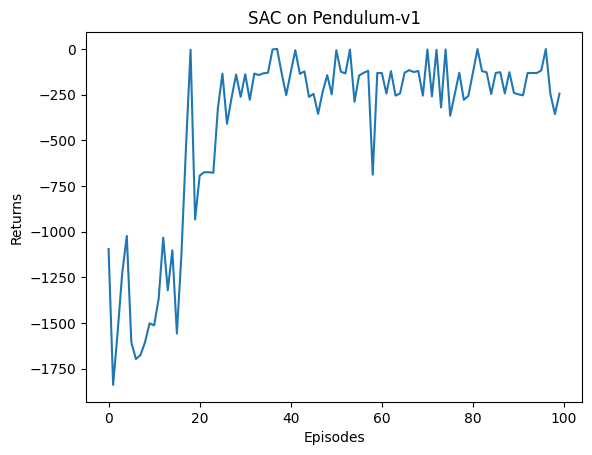

In [4]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

- 下面实现本章重点讨论的 CQL 算法，它在 SAC 的代码基础上做了修改。

In [5]:
class CQL:
    ''' CQL算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device, beta, num_random):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)
        self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                                   action_dim).to(device)
        self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                                   action_dim).to(device)
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  #对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau

        self.beta = beta  # CQL损失函数中的系数
        self.num_random = num_random  # CQL中的动作采样数

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(device)
        action = self.actor(state)[0]
        return [action.item()]

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(device)
        rewards = (rewards + 8.0) / 8.0  # 对倒立摆环境的奖励进行重塑

        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))

        # 以上与SAC相同,以下Q网络更新是CQL的额外部分
        batch_size = states.shape[0]
        random_unif_actions = torch.rand(
            [batch_size * self.num_random, actions.shape[-1]],
            dtype=torch.float).uniform_(-1, 1).to(device)
        random_unif_log_pi = np.log(0.5**next_actions.shape[-1])
        tmp_states = states.unsqueeze(1).repeat(1, self.num_random,
                                                1).view(-1, states.shape[-1])
        tmp_next_states = next_states.unsqueeze(1).repeat(
            1, self.num_random, 1).view(-1, next_states.shape[-1])
        random_curr_actions, random_curr_log_pi = self.actor(tmp_states)
        random_next_actions, random_next_log_pi = self.actor(tmp_next_states)
        q1_unif = self.critic_1(tmp_states, random_unif_actions).view(
            -1, self.num_random, 1)
        q2_unif = self.critic_2(tmp_states, random_unif_actions).view(
            -1, self.num_random, 1)
        q1_curr = self.critic_1(tmp_states, random_curr_actions).view(
            -1, self.num_random, 1)
        q2_curr = self.critic_2(tmp_states, random_curr_actions).view(
            -1, self.num_random, 1)
        q1_next = self.critic_1(tmp_states, random_next_actions).view(
            -1, self.num_random, 1)
        q2_next = self.critic_2(tmp_states, random_next_actions).view(
            -1, self.num_random, 1)
        q1_cat = torch.cat([
            q1_unif - random_unif_log_pi,
            q1_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q1_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ],
                           dim=1)
        q2_cat = torch.cat([
            q2_unif - random_unif_log_pi,
            q2_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q2_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ],
                           dim=1)

        qf1_loss_1 = torch.logsumexp(q1_cat, dim=1).mean()
        qf2_loss_1 = torch.logsumexp(q2_cat, dim=1).mean()
        qf1_loss_2 = self.critic_1(states, actions).mean()
        qf2_loss_2 = self.critic_2(states, actions).mean()
        qf1_loss = critic_1_loss + self.beta * (qf1_loss_1 - qf1_loss_2)
        qf2_loss = critic_2_loss + self.beta * (qf2_loss_1 - qf2_loss_2)

        self.critic_1_optimizer.zero_grad()
        qf1_loss.backward(retain_graph=True)
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        qf2_loss.backward(retain_graph=True)
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

- 接下来设置好超参数，就可以开始训练了。最后再绘图看一下算法的表现。因为不能通过与环境交互来获得新的数据，离线算法最终的效果和数据集有很大关系，并且波动会比较大。通常来说，调参后数据集中的样本质量越高，算法的表现就越好。感兴趣的读者可以使用其他方式生成数据集，并观察算法效果的变化。

In [6]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

beta = 5.0
num_random = 5
num_epochs = 100
num_trains_per_epoch = 500

agent = CQL(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
            critic_lr, alpha_lr, target_entropy, tau, gamma, device, beta,
            num_random)

return_list = []
for i in range(10):
    with tqdm(total=int(num_epochs / 10), desc='Iteration %d' % i) as pbar:
        for i_epoch in range(int(num_epochs / 10)):
            # 此处与环境交互只是为了评估策略,最后作图用,不会用于训练
            epoch_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                state = next_state
                epoch_return += reward
            return_list.append(epoch_return)

            for _ in range(num_trains_per_epoch):
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {
                    'states': b_s,
                    'actions': b_a,
                    'next_states': b_ns,
                    'rewards': b_r,
                    'dones': b_d
                }
                agent.update(transition_dict)

            if (i_epoch + 1) % 10 == 0:
                pbar.set_postfix({
                    'epoch':
                    '%d' % (num_epochs / 10 * i + i_epoch + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 9: 100%|██████████| 10/10 [04:02<00:00, 24.30s/it, epoch=100, return=-286.501]


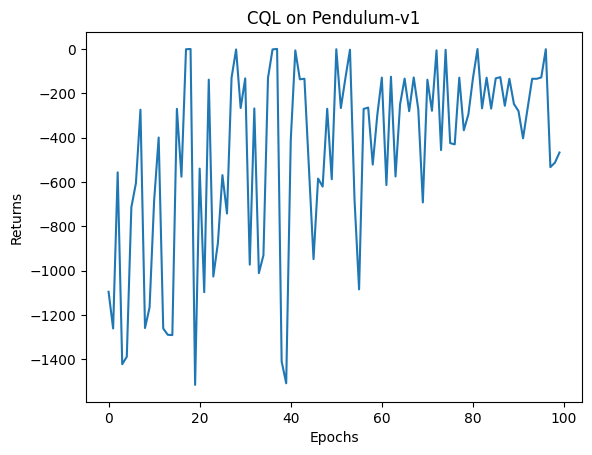

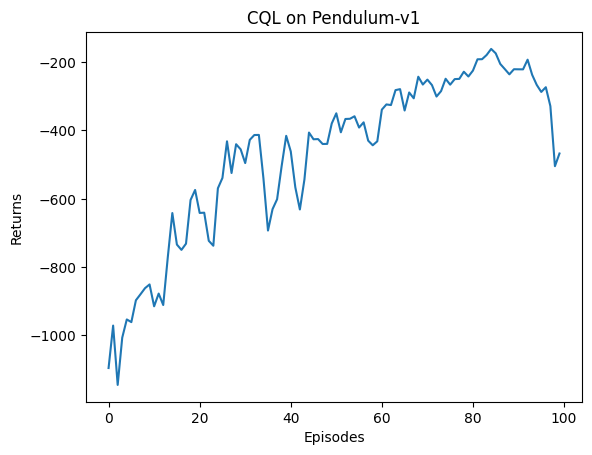

In [7]:
epochs_list = list(range(len(return_list)))
plt.plot(epochs_list, return_list)
plt.xlabel('Epochs')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

## 18.5 总结
- 本章介绍了离线强化学习的基本概念和两个与模型无关的离线强化学习算法——BCQ 和 CQL，并讲解了 CQL 的代码。事实上，离线强化学习还有一类基于模型的方法，如 model-based offline reinforcement learning （MOReL）和 model-based offline policy optimization（MOPO），本章由于篇幅原因不再介绍。这一类算法的思路基本是通过模型生成更多数据，同时通过衡量模型预测的不确定性来对生成的偏离数据集的数据进行惩罚，感兴趣的读者可以自行查阅相关资料。

- 离线强化学习的另一大难点是算法通常对超参数极为敏感，非常难调参。并且在实际复杂场景中通常不能像在模拟器中那样，每训练几轮就在环境中评估策略好坏，如何确定何时停止算法也是离线强化学习在实际应用中面临的一大挑战。此外，离线强化学习在现实场景中的落地还需要关注离散策略评估和选择、数据收集策略的保守性和数据缺失性等现实问题。不过无论如何，离线强化学习和模仿学习都是为了解决在现实中训练智能体的困难而提出的，也都是强化学习真正落地的重要途径。

## 18.6 扩展阅读
- 这里对 CQL 算法中 $\mathcal{R}(\mu) = -D_{KL}(\mu, \mathcal{U}(a))$ 的情况给出详细推导。对于一般的变量 $x \in \mathcal{D}$ 及其概率密度函数 $\mu(x)$，首先有归一化条件：

$$
\int_{\mathcal{D}}\mu(x)\operatorname{d}x=1
$$

- 把 KL 散度展开，由于 $\mathcal{U}(x) = 1 / |\mathcal{D}|$，因此得到

$$
\begin{aligned}
D_{KL}(\mu(x),\mathrm{Unif}(x)) & =\int_{\mathcal{D}}\mu(x)\log\frac{\mu(x)}{\mathcal{U}(x)}\mathrm{d}x \\
 & =\int_{\mathcal{D}}\mu(x)\log\mu(x)\operatorname{d}x-\int_{\mathcal{D}}\mu(x)\log\mathcal{U}(x)\operatorname{d}x \\
 & =\int_{\mathcal{D}}\mu(x)\log\mu(x)\operatorname{d}x-\log\frac{1}{|\mathcal{D}|}\int_{\mathcal{D}}\mu(x)\operatorname{d}x \\
 & =\int_\mathcal{D}\mu(x)\log\mu(x)\operatorname{d}x+\log|\mathcal{D}|
\end{aligned}
$$

- 回到 18.3 节，可以发现，在原迭代方程中，含有 $\mu$ 的只有 $\max_{\mu}\mathbb{E}_{s\sim\mathcal{D},a\sim\mu(a|s)}[Q(s,a)]$ 和 $\mathcal{R}(\mu)$ 两项。在分布 $\mu(a|s)$ 的条件下，状态 $s$ 是给定的，因此第一项中 $s$ 的采样和 $\mu$ 无关，第一项可以抽象为 $\max_{\mu}\mathbb{E}_{x\sim\mu(x)}[f(x)]$，此外概率密度函数应恒大于等于零，即 $\mu(x) \geq 0$。最后舍去同样和 $\mu$ 无关的常数 $\log|\mathcal{D}|$。综合起来，我们要求解如下的优化问题：

$$
\max_\mu\int_{\mathcal{D}}\mu(x)f(x)-\mu(x)\log\mu(x)\operatorname{d}x,\quad\mathrm{s.t.}\int_{\mathcal{D}}\mu(x)\operatorname{d}x=1,\mu(x)\geq0
$$

- 这一问题的求解要用到变分法。对于等式约束和不等式约束，引入拉格朗日乘数 $\lambda$ 和松弛函数 $\kappa(x)^{2}=\mu(x)-0$，得到相应的无约束优化问题：

$$
\max_\mu J(\mu),\quad J(\mu)=\int_\mathcal{D}F(x,\mu,\mu^{\prime})\operatorname{d}x=\int_\mathcal{D}f(x)\mu(x)-\mu(x)\log\mu(x)+\lambda\mu(x)\operatorname{d}x
$$

- 其中，$\mu'$ 是 $\frac{\mathrm{d}\mu}{\mathrm{d}x}$ 的简写。可以发现，$F(x, \mu, \mu')$ 事实上与 $\mu'$ 无关，可以写为 $F(x, \mu)$。代入 $\mu(x) = \kappa(x)^2$，得到：

$$
J(\kappa)=\int_{\mathcal{D}}F(x,\kappa^2)\operatorname{d}x
$$

- 写出欧拉-拉格朗日方程 ${\frac{\partial F}{\partial\kappa}}-{\frac{\mathrm{d}}{\mathrm{d}x}}{\frac{\partial F}{\partial\kappa^{\prime}}}=0$，分别计算：

$$
\frac{\partial F}{\partial\kappa}=\frac{\partial F}{\partial\mu}\frac{\partial\mu}{\partial\kappa}+\frac{\partial F}{\partial\mu^{\prime}}\frac{\partial\mu^{\prime}}{\partial\kappa}=2\kappa\frac{\partial F}{\partial\mu}+2\kappa^{\prime}\frac{\partial F}{\partial\mu^{\prime}}=2\kappa\frac{\partial F}{\partial\mu}
$$

- 由于第二项 $F$ 和 $\kappa'$ 无关，直接等于 $0$。最终拉格朗日方程简化为：

$$
2\kappa\frac{\partial F}{\partial\mu}=0
$$

- 两项的乘积等于零，因此在每一点上，要么 $\kappa(x) = 0$，即 $\mu(x) = \kappa(x)^2 = 0$，要么 $\mu(x)$ 满足 $\frac{\partial F}{\partial\mu}=0$，先来解后面的方程，直接计算得到

$$
\frac{\partial F}{\partial\mu}=f(x)+\lambda-\log\mu(x)+1=0\quad\Rightarrow\quad\mu(x)=e^{\lambda+1}e^{f(x)}
$$

- 最终的解 $\mu(x)$ 应是 $\mu(x) = \kappa(x)^2 = 0$ 和 $\mu(x)=e^{\lambda+1}e^{f(x)}$ 两者的分段组合。由于指数函数必定大于零，为了使目标泛函取到最大值，应当全部取 $\mu(x) = e^{\lambda + 1}e^{f(x)}$ 的部分。代回归一化条件，就得到原问题的最优解：

$$
\mu^*(x)=\frac{1}{Z}e^{f(x)}
$$

- 其中，$Z=\int_{\mathcal{D}}e^{f(x)}\operatorname{d}x$ 是归一化系数。此时，优化问题取到最大值，为

$$
\begin{aligned}
\mathrm{J*} & =\int_{\mathcal{D}}\mu^*(x)f(x)-\mu^*(x)\log\mu^*(x)\operatorname{d}x \\
 & =\int_{\mathcal{D}}\frac{1}{Z}e^{f(x)}f(x)-\frac{1}{Z}e^{f(x)}(f(x)-\log Z)\operatorname{d}x \\
 & =\frac{\log Z}{Z}\int_{\mathcal{D}}e^{f(x)}\operatorname{d}x \\
 & =\log Z=\log\int_{\mathcal{D}}e^{f(x)}\operatorname{d}x
\end{aligned}
$$

- 对照原迭代方程，将 $f(x)$ 改为 $f(a) = \mathbb{E}_{s \sim \mathcal{D}}[Q(s,a)]$，积分改为在动作空间上求和，上式变为：

$$
J^*=\log\sum_a\exp(\mathbb{E}_{s\sim\mathcal{D}}[Q(s,a)])
$$

- 此处的期望是对 $s$ 而言的，与 $a$ 无关，因此可以把期望移到最前面，得到：

$$
J^*=\mathbb{E}_{s\sim\mathcal{D}}\left[\log\sum_a\exp(Q(s,a))\right]
$$

- 至此，式中已经不含 $\mu$，完成简化。